# Projet de Machine Learning  UMONS 2024-2025

### Thème : Prédiction du score de Macron aux 2nd Tour des éléctions 2022

----

# Configuration et Installation des Dépendances

----

In [1]:
from utilitaires import *
print("chargement des bibliothèques et fonctions terminé")

chargement des bibliothèques et fonctions terminé


# EXPLORATION DES DONNEES

----

## 1. Chargement des données

In [2]:
print("debut du chargement des données ... .. ... ..")
data_path = "datasets"
# Chargement des données de d'entrainement et de test
print("chargement de result_train et result_test...")
result_train = pd.read_csv( os.path.join(data_path,"results_train.csv") , sep = ',',encoding='utf-8')
result_test = pd.read_csv( os.path.join(data_path,"results_test.csv") , sep = ',',encoding='utf-8')

res_train_df = result_train.copy()
res_test_df = result_test.copy()

#  Niveau de vie
print("chargement de niveau de vie ...")
niveau_vie = pd.read_excel(os.path.join(data_path, "Niveau_de_vie_2013_a_la_commune.xlsx"))
niveau_vie_df = niveau_vie.copy()

#  Communes de France
print("chargement de commune france ...")
communes_france = pd.read_csv(os.path.join(data_path, "communes-france-2022.csv"), sep=',', encoding='utf-8')
communes_df = communes_france.copy()

#  Données d'âge
print("chargement de age_insee ...")
age_insee = pd.read_excel(os.path.join(data_path, "age-insee-2020.xlsx"))
age_df = age_insee.copy()

# Données diverses INSEE
print("chargement de Insee_divers ...")
insee_divers = pd.read_excel(os.path.join(data_path, "MDB-INSEE-V2.xls"))
insee_divers_df = insee_divers.copy()

print("chargement des données terminé !! ")

debut du chargement des données ... .. ... ..
chargement de result_train et result_test...
chargement de niveau de vie ...
chargement de commune france ...
chargement de age_insee ...
chargement de Insee_divers ...
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
chargement des données terminé !! 


## 2 Analyse des données et Selection des Features


Le but ici c'est d'essayer de comprendre  les données :
* Quelles sont les données visiblement non-pertinentes ?
* regrouper les informations dans but de diminuer le nombre de features(colonnes du tableau)
* Quelles sont les paires de colonnes fortement corrélées entre elles ? 
* Laquelle garder dans chaque paire ?

----
1. Identification et élimination des colonnes à faible information

    * Objectif : Supprimer les colonnes qui ne fournissent pratiquement aucune information utile pour la prédiction.
    * Méthodes :
    Utiliser ``to_missing_values`` pour identifier les colonnes avec un pourcentage élevé de valeurs manquantes.
    Utiliser ``low_information_cols`` pour identifier les colonnes quasi-constantes ou à faible variance.
    * Visualisation :
    Afficher des histogrammes et des box plots pour les colonnes numériques identifiées.
    Afficher des bar plots pour les colonnes catégorielles identifiées.
    * Décision :
    Confirmer visuellement que les colonnes identifiées sont effectivement peu informatives.
    Supprimer ces colonnes du DataFrame.
2. Regroupement des colonnes avec une logique métier

    * Objectif : Créer de nouvelles colonnes plus significatives en combinant des colonnes existantes sur la base de votre connaissance du domaine.
    * Méthodes :
    Identifier les groupes de colonnes qui peuvent être combinés pour créer de nouvelles caractéristiques (par exemple, calcul de ratios, sommes, différences, etc.).
    Créer de nouvelles colonnes en effectuant les opérations appropriées sur les colonnes existantes.

3. Réduction des colonnes "inutiles" avec l'ACP

    * Objectif : Réduire la dimensionnalité des données en remplaçant un groupe de colonnes par un ensemble réduit de composantes principales.
    * Méthodes :
    Identifier les colonnes que vous jugez "inutiles" (c'est-à-dire, peu susceptibles d'être prédictives ou informatives).
    Appliquer l'ACP sur ces colonnes pour créer un ensemble de composantes principales.
    Sélectionner un nombre de composantes principales qui capture une proportion significative de la variance totale.
    Remplacer les colonnes originales par les composantes principales sélectionnées.
4. Élimination des paires de colonnes fortement corrélées

    * Objectif : Réduire la redondance dans les données en supprimant les colonnes qui sont fortement corrélées entre elles.
    * Méthodes :
    Utiliser la fonction ``get_correlated_pairs`` pour identifier les paires de colonnes fortement corrélées.
    Pour chaque paire de colonnes fortement corrélées, supprimer la colonne qui est la moins corrélée avec la variable cible (ou, si aucune variable cible n'est disponible, supprimer la colonne qui est la moins informative).
5. Sélection finale des colonnes à conserver

    * Objectif : Obtenir une liste finale des colonnes à conserver pour la modélisation.
    * Méthodes :
    La liste des colonnes restantes après les étapes précédentes est votre liste finale de colonnes à conserver.
    Points importants :

    * Ordre des étapes : L'ordre des étapes est important. Il est préférable d'éliminer d'abord les colonnes à faible information, puis de regrouper les colonnes avec une logique métier, puis de réduire les colonnes "inutiles" avec l'ACP, et enfin d'éliminer les paires de colonnes fortement corrélées.

### 2.1 result_train et result_test


In [3]:
# @title colonne cible à estimer
target = '% Voix/Ins' # @param {type:"string"}

In [4]:
# @title visualisation de result_train
display(res_train_df.shape)
res_train_df.head(3)

(20892, 32)

,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,N°Panneau,Sexe,Nom,Prénom,Voix,% Voix/Ins,% Voix/Exp,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,01006,Ain,Ambléon,Complet,103,19,18.450,84,81.550,12,11.650,14.290,0,0.000,0.000,72,69.900,85.710,1,M,MACRON,Emmanuel,45,43.690,62.500,2,F,LE PEN,Marine,27,26.210,37.500
1,01009,Ain,Andert-et-Condon,Complet,280,73,26.070,207,73.930,22,7.860,10.630,3,1.070,1.450,182,65.000,87.920,1,M,MACRON,Emmanuel,102,36.430,56.040,2,F,LE PEN,Marine,80,28.570,43.960
2,01010,Ain,Anglefort,Complet,792,185,23.360,607,76.640,31,3.910,5.110,8,1.010,1.320,568,71.720,93.570,1,M,MACRON,Emmanuel,227,28.660,39.960,2,F,LE PEN,Marine,341,43.060,60.040


In [5]:
# @title visualisation de result_test
display(res_test_df.shape)
res_test_df.head(3)

(13928, 5)

,CodeINSEE,Libellé du département,Libellé de la commune,Etat saisie,Inscrits
0,01001,Ain,L'Abergement-Clémenciat,Complet,643
1,01002,Ain,L'Abergement-de-Varey,Complet,213
2,01004,Ain,Ambérieu-en-Bugey,Complet,8763


In [6]:
# @title affichage des colonnes
all_col_train = all_columns(res_train_df)
all_col_test = all_columns(res_test_df)

 il y'a 32 colonnes dans le dataframe
ces colonnes sont : 
Index(['CodeINSEE', 'Libellé du département', 'Libellé de la commune',
       'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
       '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls',
       '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot',
       'N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Voix', '% Voix/Ins',
       '% Voix/Exp', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32'],
      dtype='object')

------------------------------------------------------------------------------------------

 il y'a 5 colonnes dans le dataframe
ces colonnes sont : 
Index(['CodeINSEE', 'Libellé du département', 'Libellé de la commune',
       'Etat saisie', 'Inscrits'],
      dtype='object')

------------------------------------------------------------------------------------------



In [7]:
# colonne identifiant dans result_train et result_test
id_train = 'CodeINSEE'

col_to_keep_train = inter(all_col_train, all_col_test)
col_to_keep_train = sub(col_to_keep_train,[id_train])

print(f"A part l'identifiant '{id_train}' les {len(col_to_keep_train)} colonnes communes à conservées sont {col_to_keep_train}")

A part l'identifiant 'CodeINSEE' les 4 colonnes communes à conservées sont ['Inscrits', 'Libellé de la commune', 'Etat saisie', 'Libellé du département']


on conserve les colonnes déjà présentes dans result_test car les autres sont obtenues après élection et ne ne sont pas censées être connue pour un modèle prédictif

In [8]:
# pour la suite de l'exploration des données
res_test_df[id_train] = res_test_df[id_train].astype(str).str.zfill(5)
res_train_df[id_train] = res_train_df[id_train].astype(str).str.zfill(5)


### 2.2 niveau de vie

In [9]:
# @title visualisation
display(niveau_vie_df.shape)
all_col_niveau_vie = all_columns(niveau_vie_df)
niveau_vie_df.head(3)


(36572, 4)

 il y'a 4 colonnes dans le dataframe
ces colonnes sont : 
Index(['Code Commune', 'Nom Commune', 'Niveau de vie Commune',
       'Niveau de vie Département'],
      dtype='object')

------------------------------------------------------------------------------------------



,Code Commune,Nom Commune,Niveau de vie Commune,Niveau de vie Département
0,05047,Éourres,10021.250,19202.516
1,26142,Glandage,10215.000,19300.504
2,11317,Rodome,10908.500,17599.733


In [10]:
# @title présélection
# colonnes clairement non informatives à supprimer
col_to_drop_niveau = []
id_niveau = 'Code Commune'

col_to_keep_niveau = sub(all_col_niveau_vie, col_to_drop_niveau)
col_to_keep_niveau = sub(col_to_keep_niveau , [id_niveau])

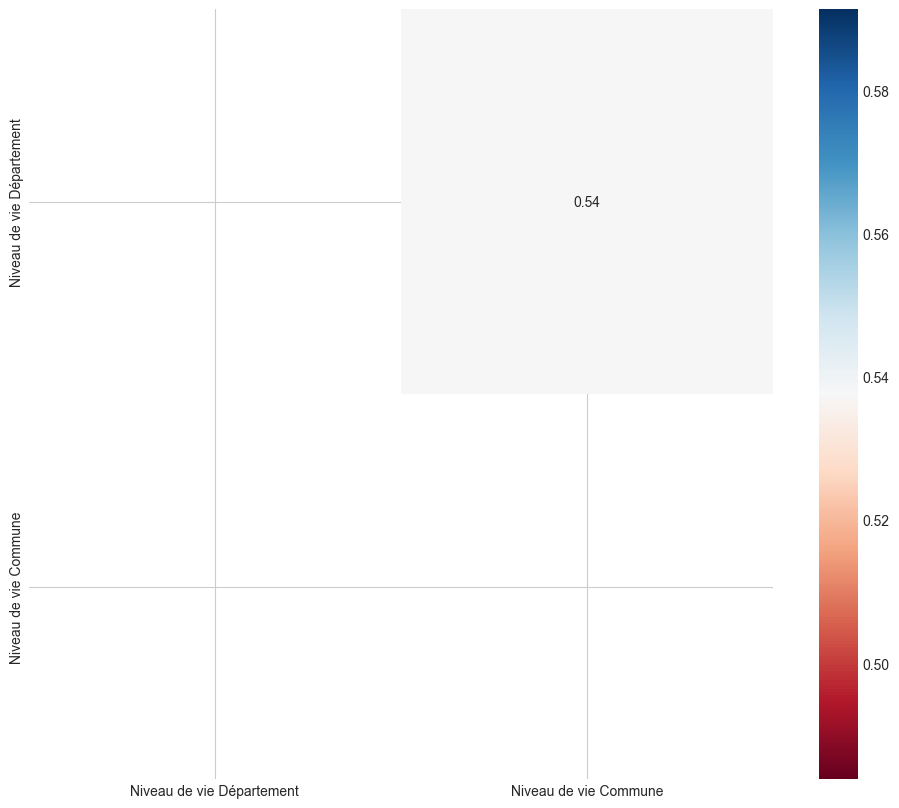

In [11]:
display_correlation_matrix(niveau_vie_df[col_to_keep_niveau], target=target,threshold=0.8 , name="corr_matrix_res_train")

on remarque que les colonnes de niveau de vie sont très peu corrélées entre elles , ce qui suggère une cetaines indépendance entre elles , donc pas besoin de les supprimer

In [12]:
print(f"A part {id_niveau} , les  {len(col_to_keep_niveau)} colonnes retenues pour niveau de vie sont : {col_to_keep_niveau}")

A part Code Commune , les  3 colonnes retenues pour niveau de vie sont : ['Nom Commune', 'Niveau de vie Département', 'Niveau de vie Commune']


### communes de frances

In [45]:
# @title visualisation
display(communes_df.shape)
all_col_communes = all_columns(communes_df)
communes_df.head(3)


(35010, 39)

 il y'a 39 colonnes dans le dataframe
ces colonnes sont : 
Index(['Unnamed: 0', 'code_insee', 'nom_standard', 'nom_sans_pronom', 'nom_a',
       'nom_de', 'nom_sans_accent', 'nom_standard_majuscule', 'typecom',
       'typecom_texte', 'reg_code', 'reg_nom', 'dep_code', 'dep_nom',
       'canton_code', 'canton_nom', 'epci_code', 'epci_nom', 'academie_code',
       'academie_nom', 'code_postal', 'codes_postaux', 'zone_emploi',
       'code_insee_centre_zone_emploi', 'population', 'superficie_hectare',
       'superficie_km2', 'densite', 'altitude_moyenne', 'altitude_minimale',
       'altitude_maximale', 'latitude_mairie', 'longitude_mairie',
       'latitude_centre', 'longitude_centre', 'grille_densite', 'gentile',
       'url_wikipedia', 'url_villedereve'],
      dtype='object')

------------------------------------------------------------------------------------------



,Unnamed: 0,code_insee,nom_standard,nom_sans_pronom,nom_a,nom_de,nom_sans_accent,nom_standard_majuscule,typecom,typecom_texte,reg_code,reg_nom,dep_code,dep_nom,canton_code,canton_nom,epci_code,epci_nom,academie_code,academie_nom,code_postal,codes_postaux,zone_emploi,code_insee_centre_zone_emploi,population,superficie_hectare,superficie_km2,densite,altitude_moyenne,altitude_minimale,altitude_maximale,latitude_mairie,longitude_mairie,latitude_centre,longitude_centre,grille_densite,gentile,url_wikipedia,url_villedereve
0,0,01001,L'Abergement-Clémenciat,Abergement-Clémenciat,à Abergement-Clémenciat,de l'Abergement-Clémenciat,l-abergement-clemenciat,L'ABERGEMENT-CLÉMENCIAT,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0108,Châtillon-sur-Chalaronne,200069193,CC de la Dombes,10,Lyon,1400,01400,8405.000,01053,779,1565,16,48.700,242,206.000,272.000,46.153,4.926,46.153,4.926,Rural à habitat dispersé,NaN,https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01001-l-abergemen...
1,1,01002,L'Abergement-de-Varey,Abergement-de-Varey,à Abergement-de-Varey,de l'Abergement-de-Varey,l-abergement-de-varey,L'ABERGEMENT-DE-VAREY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1640,01640,8405.000,01053,256,912,9,27.100,483,290.000,748.000,46.009,5.428,46.009,5.428,Rural à habitat dispersé,"Abergementais, Abergementaises",https://fr.wikipedia.org/wiki/fr:L'Abergement-...,https://villedereve.fr/ville/01002-l-abergemen...
2,2,01004,Ambérieu-en-Bugey,Ambérieu-en-Bugey,à Ambérieu-en-Bugey,d'Ambérieu-en-Bugey,amberieu-en-bugey,AMBÉRIEU-EN-BUGEY,COM,commune,84,Auvergne-Rhône-Alpes,01,Ain,0101,Ambérieu-en-Bugey,240100883,CC de la Plaine de l'Ain,10,Lyon,1500,"01500, 01501, 01504, 01503, 01502, 01505, 01506",8405.000,01053,14134,2448,24,570.500,379,237.000,753.000,45.961,5.373,45.961,5.373,Centres urbains intermédiaires,"Ambarrois, Ambarroises",https://fr.wikipedia.org/wiki/fr:Ambérieu-en-B...,https://villedereve.fr/ville/01004-amberieu-en...


In [46]:
# @title présélection
id_commune = 'code_insee'
# colonnes jugées non informatives à supprimer immédiatement
col_to_drop_commune = low_information_cols(communes_df.copy(), constant_threshold=0.3, missing_threshold = 0.7)
print(col_to_drop_commune)

['typecom', 'gentile', 'typecom_texte']


In [47]:

group_inutiles = ['url_wikipedia','url_villedereve',
                       'typecom','typecom_texte',
                       'nom_standard','nom_a','nom_de',
                       'nom_sans_pronom','gentile',
                       'nom_sans_accent','nom_standard_majuscule',
                       'superficie_hectare','Unnamed: 0',
                       'academie_nom','codes postaux',
                       'longitude_centre','latitude_centre',
                       'reg_nom','dep_nom','canton_nom','epci_nom']

group_inutiles = sub(group_inutiles,col_to_drop_commune)

print(group_inutiles)


['canton_nom', 'nom_sans_accent', 'nom_a', 'epci_nom', 'nom_sans_pronom', 'reg_nom', 'url_wikipedia', 'url_villedereve', 'academie_nom', 'codes postaux', 'latitude_centre', 'nom_de', 'Unnamed: 0', 'longitude_centre', 'nom_standard', 'superficie_hectare', 'nom_standard_majuscule', 'dep_nom']


In [38]:
col_to_keep_commune = sub(sub(all_col_communes,col_to_drop_commune),[id_commune])
display(col_to_keep_commune)


['dep_code',
 'academie_code',
 'zone_emploi',
 'nom_a',
 'epci_nom',
 'grille_densite',
 'longitude_mairie',
 'codes_postaux',
 'Unnamed: 0',
 'nom_de',
 'reg_code',
 'superficie_km2',
 'longitude_centre',
 'nom_standard',
 'superficie_hectare',
 'densite',
 'latitude_mairie',
 'altitude_maximale',
 'canton_nom',
 'nom_sans_accent',
 'nom_sans_pronom',
 'canton_code',
 'reg_nom',
 'population',
 'url_wikipedia',
 'url_villedereve',
 'academie_nom',
 'code_insee_centre_zone_emploi',
 'latitude_centre',
 'altitude_moyenne',
 'epci_code',
 'nom_standard_majuscule',
 'code_postal',
 'altitude_minimale',
 'dep_nom']

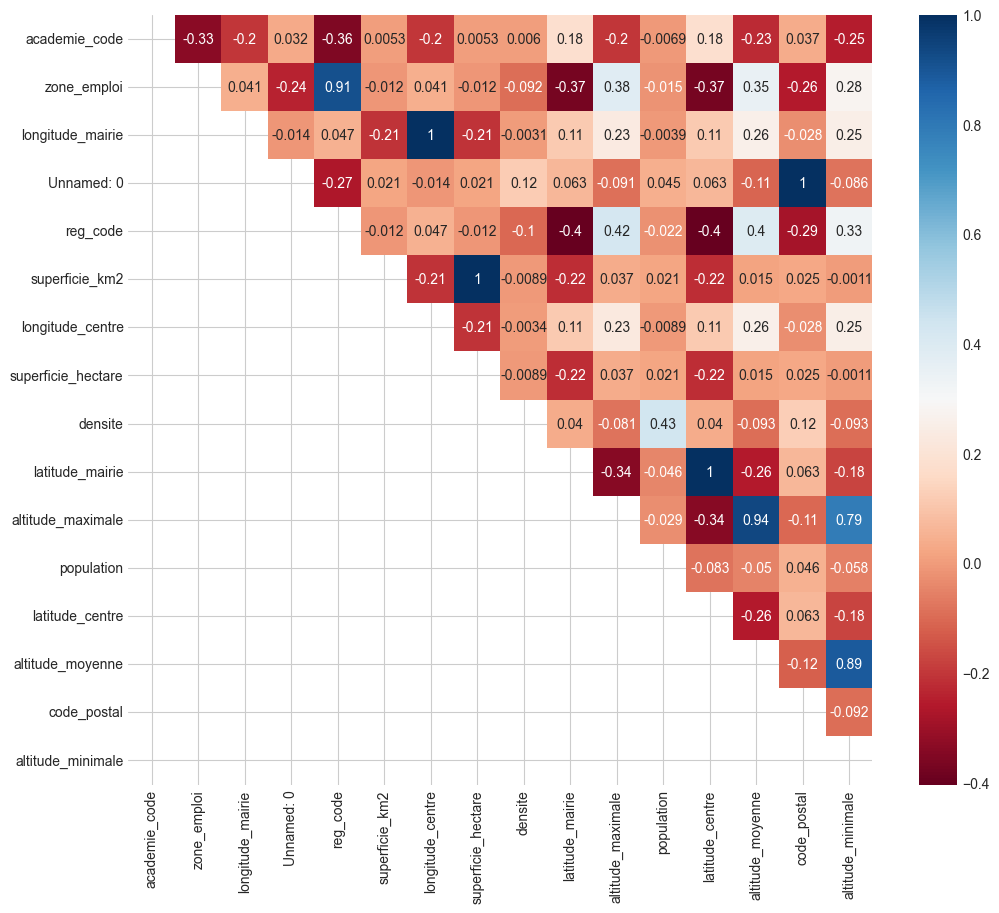

In [39]:
display_correlation_matrix( communes_df[col_to_keep_commune], name="corr_commune")

In [40]:
get_correlated_pairs(communes_df[col_to_keep_commune], threshold=0.7)


Paires de colonnes fortement corrélées (|corr| >= 0.7):
longitude_mairie     - longitude_centre    : 1.000
latitude_mairie      - latitude_centre     : 1.000
superficie_km2       - superficie_hectare  : 1.000
Unnamed: 0           - code_postal         : 0.997
altitude_maximale    - altitude_moyenne    : 0.935
zone_emploi          - reg_code            : 0.915
altitude_moyenne     - altitude_minimale   : 0.887
altitude_maximale    - altitude_minimale   : 0.788

------------------------------------------------------------------------------------------



[('longitude_mairie', 'longitude_centre', np.float64(1.0)),
 ('latitude_mairie', 'latitude_centre', np.float64(1.0)),
 ('superficie_km2', 'superficie_hectare', np.float64(0.9999980776626322)),
 ('Unnamed: 0', 'code_postal', np.float64(0.9971718512311408)),
 ('altitude_maximale', 'altitude_moyenne', np.float64(0.9353913890922777)),
 ('zone_emploi', 'reg_code', np.float64(0.9146226698833776)),
 ('altitude_moyenne', 'altitude_minimale', np.float64(0.8865963123610062)),
 ('altitude_maximale', 'altitude_minimale', np.float64(0.7875556754732763))]

In [41]:
communes_df[id_commune] = communes_df[id_commune].astype(str).str.zfill(5)

com_merge_train = res_train_df.copy()[[id_train,target]].merge(communes_df[col_to_keep_commune +[id_commune]], left_on=id_train, right_on=id_commune, how='left').drop(columns=[id_train,id_commune])

In [42]:
com_merge_train.head(5)

,% Voix/Ins,dep_code,academie_code,zone_emploi,nom_a,epci_nom,grille_densite,longitude_mairie,codes_postaux,Unnamed: 0,nom_de,reg_code,superficie_km2,longitude_centre,nom_standard,superficie_hectare,densite,latitude_mairie,altitude_maximale,canton_nom,nom_sans_accent,nom_sans_pronom,canton_code,reg_nom,population,url_wikipedia,url_villedereve,academie_nom,code_insee_centre_zone_emploi,latitude_centre,altitude_moyenne,epci_code,nom_standard_majuscule,code_postal,altitude_minimale,dep_nom
0,43.690,01,10,8404.000,à Ambléon,CC Bugey Sud,Rural à habitat dispersé,5.594,01300,4,d'Ambléon,84,6,5.594,Ambléon,602,18.900,45.750,940.000,Belley,ambleon,Ambléon,0104,Auvergne-Rhône-Alpes,112,https://fr.wikipedia.org/wiki/fr:Ambléon,https://villedereve.fr/ville/01006-ambleon,Lyon,01034,45.750,589,200040350,AMBLÉON,1300,330.000,Ain
1,36.430,01,10,8404.000,à Andert-et-Condon,CC Bugey Sud,Rural à habitat dispersé,5.658,01300,7,d'Andert-et-Condon,84,7,5.658,Andert-et-Condon,696,47.600,45.787,374.000,Belley,andert-et-condon,Andert-et-Condon,0104,Auvergne-Rhône-Alpes,326,https://fr.wikipedia.org/wiki/fr:Andert-et-Condon,https://villedereve.fr/ville/01009-andert-et-c...,Lyon,01034,45.787,294,200040350,ANDERT-ET-CONDON,1300,225.000,Ain
2,28.660,01,10,8416.000,à Anglefort,CC Usses et Rhône,Bourgs ruraux,5.795,01350,8,d'Anglefort,84,29,5.795,Anglefort,2948,38.100,45.909,1524.000,Hauteville-Lompnes,anglefort,Anglefort,0110,Auvergne-Rhône-Alpes,1105,https://fr.wikipedia.org/wiki/fr:Anglefort,https://villedereve.fr/ville/01010-anglefort,Lyon,74012,45.909,706,200070852,ANGLEFORT,1350,238.000,Ain
3,34.950,01,10,8425.000,à Apremont,CA Haut - Bugey Agglomération,Rural à habitat dispersé,5.658,01100,9,d'Apremont,84,15,5.658,Apremont,1507,25.800,46.206,1042.000,Nantua,apremont,Apremont,0114,Auvergne-Rhône-Alpes,368,https://fr.wikipedia.org/wiki/fr:Apremont (Ain),https://villedereve.fr/ville/01011-apremont,Lyon,01283,46.206,927,200042935,APREMONT,1100,658.000,Ain
4,32.510,01,10,8404.000,à Aranc,CA Haut - Bugey Agglomération,Rural à habitat dispersé,5.511,01110,10,d'Aranc,84,22,5.511,Aranc,2172,15.100,46.002,1011.000,Hauteville-Lompnes,aranc,Aranc,0110,Auvergne-Rhône-Alpes,329,https://fr.wikipedia.org/wiki/fr:Aranc,https://villedereve.fr/ville/01012-aranc,Lyon,01034,46.002,795,200042935,ARANC,1110,431.000,Ain


In [ ]:
col_to_keep_commune , drop_temp = select_best_features(com_merge_train, target=target, threshold=0.7)
display(col_to_keep_commune)



Colonnes  éliminées: ['Unnamed: 0', 'altitude_minimale', 'altitude_moyenne', 'latitude_centre', 'latitude_mairie', 'longitude_centre', 'reg_code', 'superficie_km2']
Colonnes  conservées: ['academie_code', 'academie_nom', 'altitude_maximale', 'canton_code', 'canton_nom', 'code_insee_centre_zone_emploi', 'code_postal', 'codes_postaux', 'densite', 'dep_code', 'dep_nom', 'epci_code', 'epci_nom', 'grille_densite', 'longitude_mairie', 'nom_a', 'nom_de', 'nom_sans_accent', 'nom_sans_pronom', 'nom_standard', 'nom_standard_majuscule', 'population', 'reg_nom', 'superficie_hectare', 'url_villedereve', 'url_wikipedia', 'zone_emploi']


['dep_code',
 'academie_code',
 'zone_emploi',
 'nom_a',
 'epci_nom',
 'grille_densite',
 'longitude_mairie',
 'codes_postaux',
 'nom_de',
 'nom_standard',
 'superficie_hectare',
 'densite',
 'altitude_maximale',
 'canton_nom',
 'nom_sans_accent',
 'nom_sans_pronom',
 'canton_code',
 'reg_nom',
 'population',
 'url_wikipedia',
 'url_villedereve',
 'academie_nom',
 'code_insee_centre_zone_emploi',
 'epci_code',
 'nom_standard_majuscule',
 'code_postal',
 'dep_nom']

"colonnes à supprimer... ['typecom', 'gentile', 'typecom_texte', 'latitude_centre', 'Unnamed: 0', 'altitude_moyenne', 'superficie_km2', 'reg_code', 'longitude_centre', 'altitude_minimale', 'latitude_mairie']"

"groupes considéré inutiles ['codes postaux', 'canton_nom', 'nom_de', 'nom_sans_accent', 'nom_sans_pronom', 'nom_a', 'epci_nom', 'reg_nom', 'url_wikipedia', 'nom_standard', 'url_villedereve', 'superficie_hectare', 'nom_standard_majuscule', 'academie_nom', 'dep_nom']"

In [44]:
col_to_drop_commune = col_to_drop_commune.extend(drop_temp)
display(f"colonnes à supprimer... {col_to_drop_commune}")
group_inutiles = sub(group_inutiles,drop_temp)
display(f"groupes considéré inutiles {group_inutiles}")


'colonnes à supprimer... None'

"groupes considéré inutiles ['codes postaux', 'canton_nom', 'nom_de', 'nom_sans_accent', 'nom_sans_pronom', 'nom_a', 'epci_nom', 'reg_nom', 'url_wikipedia', 'nom_standard', 'url_villedereve', 'superficie_hectare', 'nom_standard_majuscule', 'academie_nom', 'dep_nom']"

In [ ]:
print(f"A part '{id_commune}' , les  {len(col_to_keep_commune)} colonnes retenues pour commune france sont : {col_to_keep_commune}")

A part code_insee , les  27 colonnes retenues pour commune france sont : ['dep_code', 'academie_code', 'zone_emploi', 'nom_a', 'epci_nom', 'grille_densite', 'longitude_mairie', 'codes_postaux', 'nom_de', 'nom_standard', 'superficie_hectare', 'densite', 'altitude_maximale', 'canton_nom', 'nom_sans_accent', 'nom_sans_pronom', 'canton_code', 'reg_nom', 'population', 'url_wikipedia', 'url_villedereve', 'academie_nom', 'code_insee_centre_zone_emploi', 'epci_code', 'nom_standard_majuscule', 'code_postal', 'dep_nom']


---

### age-insee

In [23]:
# @title visualisation
visualise(age_df)


NameError: name 'visualise' is not defined

In [ ]:
age_df.head(5)


,INSEE,NOM,EPCI,DEP,REG,F0-2,F3-5,F6-10,F11-17,F18-24,F25-39,F40-54,F55-64,F65-79,F80+,Unnamed: 15,H0-2,H3-5,H6-10,H11-17,H18-24,H25-39,H40-54,H55-64,H65-79,H80+
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,13.414,12.509,19.214,37.182,14.062,70.119,84.512,60.032,64.311,20.164,NaN,18.070,14.403,34.540,40.257,14.231,72.498,81.849,61.039,55.240,18.353
1,1002,L'Abergement-de-Varey,240100883,D1,R84,2.994,6.050,12.232,11.869,5.202,20.498,33.975,12.365,12.419,7.027,NaN,2.994,6.116,6.953,22.349,6.394,19.540,37.479,10.977,15.687,8.879
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,294.668,245.153,382.801,599.105,680.831,1451.111,1268.502,903.062,1064.992,517.133,NaN,256.304,289.985,485.793,613.182,669.385,1542.699,1238.120,782.771,750.040,252.364
3,1005,Ambérieux-en-Dombes,200042497,D1,R84,28.000,33.000,60.000,79.000,50.000,184.000,190.000,117.000,104.000,44.000,NaN,35.000,36.000,65.000,78.000,51.000,181.000,183.000,124.000,108.000,32.000
4,1006,Ambléon,200040350,D1,R84,0.991,1.982,1.982,0.991,1.982,9.912,6.939,9.912,14.868,3.965,NaN,1.982,0.991,1.982,0.991,3.965,11.895,10.904,13.877,10.904,1.982


In [ ]:
# @title Présélection
# visuellement
col_to_drop_age = get_columns_above_missing_threshold(age_df, threshold=0.5)[0]

print(f"Colonnes à supprimer {col_to_drop_age}")

id_age = 'INSEE'
all_col_age = age_df.columns.tolist()
col_to_keep_age = sub(sub(all_col_age , col_to_drop_age), [id_age])
print(f"Colonnes à conserver {col_to_keep_age}")

Colonnes à supprimer ['Unnamed: 15']
Colonnes à conserver ['H55-64', 'H18-24', 'H3-5', 'H80+', 'NOM', 'F80+', 'H25-39', 'H65-79', 'H11-17', 'F0-2', 'F11-17', 'H40-54', 'F3-5', 'H0-2', 'F6-10', 'H6-10', 'F18-24', 'F25-39', 'F40-54', 'DEP', 'F65-79', 'REG', 'F55-64', 'EPCI']


#### Regroupement des âges

In [ ]:
age_groups = age_df[age_df.columns[:5]]

# colonne des genres
col_Hom = [col for col in age_df.columns if col.startswith('H')] # les hommes
col_fem = [col for col in age_df.columns if col.startswith('F')] # les femmes

# population totale par commune
age_groups['Population'] = age_df[col_fem].sum(axis=1) + age_df[col_Hom].sum(axis=1)

#-----------------------
# regroupement par sexe
#-----------------------
age_groups['% Hommes'] = age_df[col_Hom].sum(axis=1)/ age_groups['Population'] #ratio hommes
age_groups['% Femmes'] = age_df[col_fem].sum(axis=1)/ age_groups['Population'] #ratio femmes

In [ ]:
#-------------------------------------------------------------
# Regroupement par cycle de vie et d'activité professionnelle
#-------------------------------------------------------------

# ratio des enfants et les adolesscents (0-17 ans)
age_groups['% Enfants_Adolescents'] = (
    age_df['F0-2'] + age_df['F3-5'] + age_df['F6-10'] + age_df['F11-17'] +
    age_df['H0-2'] + age_df['H3-5'] + age_df['H6-10'] + age_df['H11-17']
) / age_groups['Population']

# ratio de jeunes adultes (18-24 ans)
age_groups['% Jeunes_adultes'] = (
    age_df['F18-24'] + age_df['H18-24']
) / age_groups['Population']

# ratio des adultes professionellement actifs (25-64 ans)
age_groups['% Actifs'] = (
    age_df['F25-39'] + age_df['F40-54'] + age_df['F55-64'] +
    age_df['H25-39'] + age_df['H40-54'] + age_df['H55-64']
) / age_groups['Population']

# ratio des retraités (65 ans et plus)
age_groups['% Retraites'] = (
    age_df['F65-79'] + age_df['F80+'] +
    age_df['H65-79'] + age_df['H80+']
) / age_groups['Population']



In [ ]:
age_groups.to_csv(os.path.join("Tables","age_groups.csv"),index=False)
age_groups.head(4)


,INSEE,NOM,EPCI,DEP,REG,Population,% Hommes,% Femmes,% Enfants_Adolescents,% Jeunes_adultes,% Actifs,% Retraites
0,1001,L'Abergement-Clémenciat,200069193,D1,R84,806.000,0.509,0.491,0.235,0.035,0.534,0.196
1,1002,L'Abergement-de-Varey,240100883,D1,R84,262.000,0.524,0.476,0.273,0.044,0.515,0.168
2,1004,Ambérieu-en-Bugey,240100883,D1,R84,14288.000,0.482,0.518,0.222,0.094,0.503,0.181
3,1005,Ambérieux-en-Dombes,200042497,D1,R84,1782.000,0.501,0.499,0.232,0.057,0.549,0.162


#### elimination des colonnes fortement correlées entre elles

In [ ]:
all_col_age_group = all_columns(age_groups)
col_to_keep_age = sub(all_col_age_group, [id_age])


les colonnes sont : 
Index(['INSEE', 'NOM', 'EPCI', 'DEP', 'REG', 'Population', '% Hommes',
       '% Femmes', '% Enfants_Adolescents', '% Jeunes_adultes', '% Actifs',
       '% Retraites'],
      dtype='object')
 il y'a 12 colonnes dans le dataframe

------------------------------------------------------------------------------------------



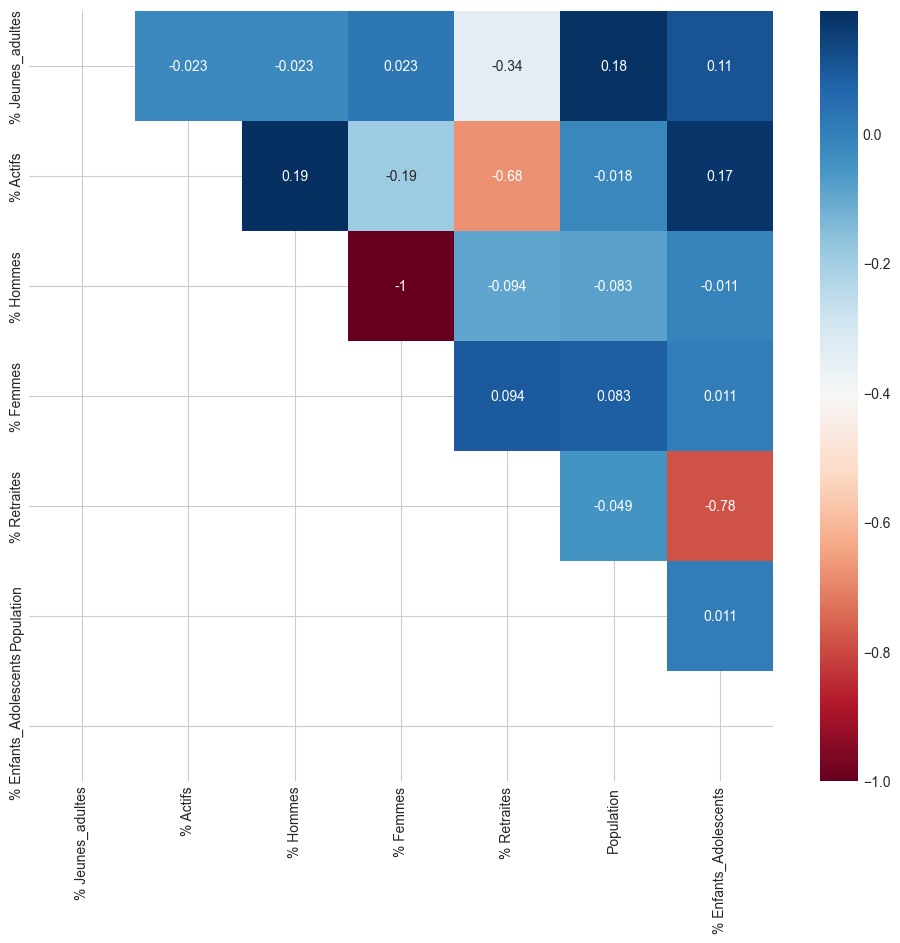

In [ ]:
display_correlation_matrix(age_groups.copy()[col_to_keep_age],name="corr_age")

In [ ]:
get_correlated_pairs(age_groups.copy()[col_to_keep_age], threshold=0.7)



Paires de colonnes fortement corrélées (|corr| >= 0.7):
% Hommes             - % Femmes            : -1.000
% Retraites          - % Enfants_Adolescents: -0.784

------------------------------------------------------------------------------------------



[('% Hommes', '% Femmes', np.float64(-0.9999999999999999)),
 ('% Retraites', '% Enfants_Adolescents', np.float64(-0.784489203248469))]

In [ ]:
age_groups[id_age] = age_groups[id_age].astype(str).str.zfill(5)
age_merge_train = res_train_df.copy()[[id_train,target]].merge(age_groups, left_on=id_train, right_on=id_age, how='left').drop(columns=[id_train,id_age])



In [ ]:
age_merge_train.head(5)

,% Voix/Ins,NOM,EPCI,DEP,REG,Population,% Hommes,% Femmes,% Enfants_Adolescents,% Jeunes_adultes,% Actifs,% Retraites
0,43.690,Ambléon,200040350,D1,R84,113.000,0.526,0.474,0.105,0.053,0.561,0.281
1,36.430,Andert-et-Condon,200040350,D1,R84,324.000,0.508,0.492,0.192,0.054,0.468,0.285
2,28.660,Anglefort,200070852,D1,R84,1101.000,0.491,0.509,0.265,0.042,0.527,0.166
3,34.950,Apremont,200042935,D1,R84,368.000,0.510,0.490,0.263,0.029,0.527,0.181
4,32.510,Aranc,200042935,D1,R84,327.000,0.512,0.488,0.234,0.034,0.472,0.260


In [ ]:
to_holes_age = get_columns_above_missing_threshold(age_merge_train, threshold=0.99)[0]

print(to_holes_age)

[]


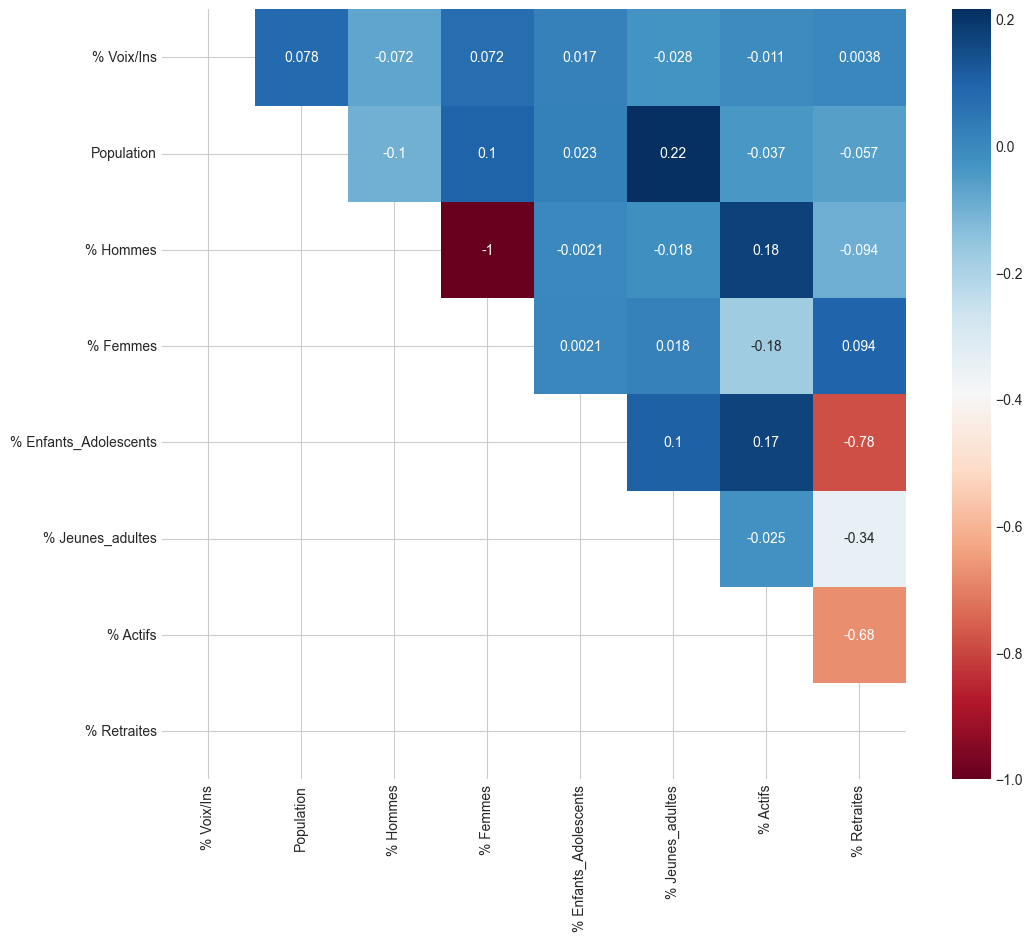

In [ ]:
display_correlation_matrix(age_merge_train, name="corr_age_merge_train")

In [ ]:
col_to_keep_age = select_best_features(age_merge_train, target=target, threshold=0.7)


Colonnes  éliminées: ['% Femmes', '% Retraites']
Colonnes  conservées: ['% Actifs', '% Enfants_Adolescents', '% Hommes', '% Jeunes_adultes', 'DEP', 'EPCI', 'NOM', 'Population', 'REG']


In [ ]:
print(f" à part {id_age} , les {len(col_to_keep_age)} colonnes retenues pour age sont : {col_to_keep_age}")

 à part INSEE , les 9 colonnes retenues pour age sont : ['NOM', 'EPCI', 'DEP', 'REG', 'Population', '% Hommes', '% Enfants_Adolescents', '% Jeunes_adultes', '% Actifs']


---

### Mdb_insee_divers

In [ ]:
# @title visualisation
visualise(insee_divers_df)

insee_divers_df.head(3)

forme : (36677, 101)


,CODGEO,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,SEG Croissance POP,LIBGEO,REG,DEP,Nb Omnipraticiens BV,Nb Infirmiers Libéraux BV,Nb dentistes Libéraux BV,Nb pharmaciens Libéraux BV,Densité Médicale BV,Score équipement de santé BV,Indice Démographique,Score Démographique,Indice Ménages,Score Ménages,Population,Evolution Population,Evolution Pop %,Nb Ménages,Nb Résidences Principales,Nb propriétaire,Nb Logement,Nb Résidences Secondaires,Nb Log Vacants,Nb Occupants Résidence Principale,Nb Femme,Nb Homme,Nb Mineurs,Nb Majeurs,Nb Etudiants,Nb Entreprises Secteur Services,Nb Entreprises Secteur Commerce,Nb Entreprises Secteur Construction,Nb Entreprises Secteur Industrie,Nb Création Enteprises,Nb Création Industrielles,Nb Création Construction,Nb Création Commerces,Nb Création Services,Moyenne Revenus Fiscaux Départementaux,Moyenne Revenus Fiscaux Régionaux,Dep Moyenne Salaires Horaires,Dep Moyenne Salaires Cadre Horaires,Dep Moyenne Salaires Prof Intermédiaire Horaires,Dep Moyenne Salaires Employé Horaires,Dep Moyenne Salaires Ouvrié Horaires,Reg Moyenne Salaires Horaires,Reg Moyenne Salaires Cadre Horaires,Reg Moyenne Salaires Prof Intermédiaire Horaires,Reg Moyenne Salaires Employé Horaires,Reg Moyenne Salaires Ouvrié Horaires,Valeur ajoutée régionale,Urbanité Ruralité,Score Urbanité,Nb Atifs,Nb Actifs Salariés,Nb Actifs Non Salariés,Nb Logement Secondaire et Occasionnel,Nb Hotel,Capacité Hotel,Nb Camping,Capacité Camping,Dynamique Démographique BV,Taux étudiants,Taux Propriété,Dynamique Démographique INSEE,Capacité Fisc,Capacité Fiscale,Moyenne Revnus fiscaux,Taux Evasion Client,"Nb Education, santé, action sociale",Nb Services personnels et domestiques,"Nb Santé, action sociale",Nb Industries des biens intermédiaires,Nb de Commerce,Nb de Services aux particuliers,"Nb institution de Education, santé, action sociale, administration",PIB Régionnal,SEG Environnement Démographique Obsolète,Score Croissance Population,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.000,57.000,23.000,114,Bassin Industriel,101.939,59.041,0.000,0.000,114.567,0.135,en croissance démographique,L' Abergement-Clémenciat,82,01,9,14,7,7,0.093,4,44.198,0.034,37.220,0.022,725,16,2,247,248,196,289,32,9,728,694,714,909,499,51,7.000,11.000,2.000,2.000,4.000,0.000,2.000,1.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,295.000,254.000,41.000,32.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,67,-1,117,117,11483.500,0,3.000,1.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.016,32.426,33.838,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.000,45.000,4.000,143,Bassin Résidentiel,101.939,59.041,0.000,0.000,143.711,0.174,en croissance démographique,L' Abergement-de-Varey,82,01,31,36,18,18,0.099,4,10.181,0.008,10.096,0.006,167,4,2,67,67,61,142,71,4,168,162,164,202,124,5,4.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,12509,10458,11.410,21.964,12.559,8.743,9.269,11.873,21.788,12.704,8.783,9.301,86957.458,Com rurale < 2 000 m habts,0.000,57.000,49.000,8.000,71.000,0.000,0.000,0.000,0.000,1.Accroissement par excédent naturel et migrat...,0,42,0,110,110,11483.500,0,0.000,0.000,0.000,9364,9350,3372,15105,173681,Zone rurale en croissance démographique,72.131,0.002,32.426,33.838,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
2,01004,0.000,634.000,828.000,366,Bassin R

In [ ]:
# @title affichage des colonnes
all_col_insee_divers = all_columns(insee_divers_df)

les colonnes sont : 
Index(['CODGEO', 'Nb Pharmacies et parfumerie', 'Dynamique Entrepreneuriale',
       'Dynamique Entrepreneuriale Service et Commerce',
       'Synergie Médicale COMMUNE', 'Orientation Economique',
       'Indice Fiscal Partiel', 'Score Fiscal', 'Indice Evasion Client',
       'Score Evasion Client',
       ...
       'Score Croissance Entrepreneuriale', 'Score VA Région', 'Score PIB',
       'Environnement Démographique', 'Fidélité', 'SYN MEDICAL',
       'Seg Cap Fiscale', 'Seg Dyn Entre', 'DYN SetC', 'CP'],
      dtype='object', length=101)
 il y'a 101 colonnes dans le dataframe

------------------------------------------------------------------------------------------



In [ ]:
# @title présélection
id_mdb = 'CODGEO'
# colonnes jugées non informatives ou trop difficile à manipuler
col_to_drop_mdb = ['Nb Résidences Principales','Nb Log Vacants' ,
                   'Nb Résidences Secondaires',
                   'Score démographique' , 'Score Ménages' ,
                   'Evolution Pop %','Score Fiscal',
                   'Score Evasion Client','Score Synergie Médicale',
                   'Population','Nb Logement Secondaires',
                   'Capacité Camping', 'Capacité Hotel',
                   'Dynamique Démographique BV', 'Capacité Fisc',
                   'CP' , 'Urbanité Ruralité' , 'SEG Environnement Démographique Obsolète']
to_holes_insee = get_columns_above_missing_threshold(insee_divers_df, threshold=0.7)[0]
col_to_drop_mdb = list(set(col_to_drop_mdb) | set(to_holes_insee))

In [ ]:
display(col_to_drop_mdb)

['Capacité Camping',
 'Capacité Hotel',
 'Capacité Fisc',
 'Score Evasion Client',
 'CP',
 'Score Synergie Médicale',
 'Population',
 'Score Fiscal',
 'Score Ménages',
 'Score démographique',
 'Nb Log Vacants',
 'Evolution Pop %',
 'Nb Logement Secondaires',
 'Nb Résidences Principales',
 'Urbanité Ruralité',
 'SEG Environnement Démographique Obsolète',
 'Dynamique Démographique BV',
 'Nb Résidences Secondaires']

In [ ]:

# les colonnes à  regrouper
HF = ['Nb Homme' , 'Nb Femme']

mM = ['Nb Mineurs' , 'Nb Majeurs']

Nb_entreprises = ['Nb Entreprises Secteur Commerce' ,
                  'Nb Entreprises Secteur Construction',
                  'Nb Entreprises Secteur Industrie' ,
                  'Nb Entreprises Secteur Services']

Nb_medecins = ['Nb Omnipraticiens BV' ,
             'Nb Infirmiers Libéraux BV',
             'Nb dentistes Libéraux BV',
             'Nb pharmaciens Libéraux BV']

Indice_creation_eco = ['Nb Création Enteprises' ,
                    'Nb Création Industrielles',
                    'Nb Création Construction',
                    'Nb Création Commerces',
                    'Nb création Services']

Indice_fiscal = ['Moyenne Revenus Fiscaux Départementaux',
                 'Moyenne Revenus Fiscaux Régionaux']

Indice_social =['Nb Education, santé, action sociale',
                'Nb Santé, action sociale',
                'Nb institution de Education, santé, action sociale, administration']

Indice_services = ['Nb Services personnels et domestiques',
                   'Nb Industries des biens intermédiaires',
                   'Nb de Commerce',
                   'Nb de Services aux particuliers']

Indice_salaire_global = ['Dep Moyenne Salaires Horaires',
                         'Reg Moyenne Salaires Horaires',]

indice_salaire_csp = ['Dep Moyenne Salaires Cadre Horaires',
                      'Reg Moyenne Salaires Cadre Horaires',
                      'Dep Moyenne Salaires Prof Intermédiaire Horaires',
                      'Reg Moyenne Salaires Prof Intermédiaire Horaires',
                      'Dep Moyenne Salaires Employé Horaires',
                      'Reg Moyenne Salaires Employé Horaires',
                      'Dep Moyenne Salaires Ouvrié Horaires',
                      'Reg Moyenne Salaires Ouvrié Horaires']

dict_indice_salaire = {
    'indice_salaire_global': Indice_salaire_global,
    **{'indice_salaire_'+str(i) : indice_salaire_csp[i:i+2] for i in range(0, len(indice_salaire_csp), 2)}
}

col_to_drop_mdb += HF + mM + Nb_entreprises + Nb_medecins + Indice_creation_eco + Indice_fiscal + Indice_salaire_global + indice_salaire_csp + Indice_services + Indice_social

col_to_keep5 = sub(all_col_insee_divers,col_to_drop_mdb)



# Dictionnaire de correspondance pour les nouveaux noms
nouveaux_noms = {
    'indice_salaire_0': 'indice_salaire_cadre',
    'indice_salaire_2': 'indice_salaire_prof',
    'indice_salaire_4': 'indice_salaire_employé',
    'indice_salaire_6': 'indice_salaire_ouvrié'
}

for old_key, new_key in nouveaux_noms.items():
    if old_key in dict_indice_salaire:
        dict_indice_salaire[new_key] = dict_indice_salaire.pop(old_key)

# Vérification
for k, v in dict_indice_salaire.items():
    print(f"{k} : {v}")
# ...existing code...

indice_salaire_global : ['Dep Moyenne Salaires Horaires', 'Reg Moyenne Salaires Horaires']
indice_salaire_cadre : ['Dep Moyenne Salaires Cadre Horaires', 'Reg Moyenne Salaires Cadre Horaires']
indice_salaire_prof : ['Dep Moyenne Salaires Prof Intermédiaire Horaires', 'Reg Moyenne Salaires Prof Intermédiaire Horaires']
indice_salaire_employé : ['Dep Moyenne Salaires Employé Horaires', 'Reg Moyenne Salaires Employé Horaires']
indice_salaire_ouvrié : ['Dep Moyenne Salaires Ouvrié Horaires', 'Reg Moyenne Salaires Ouvrié Horaires']


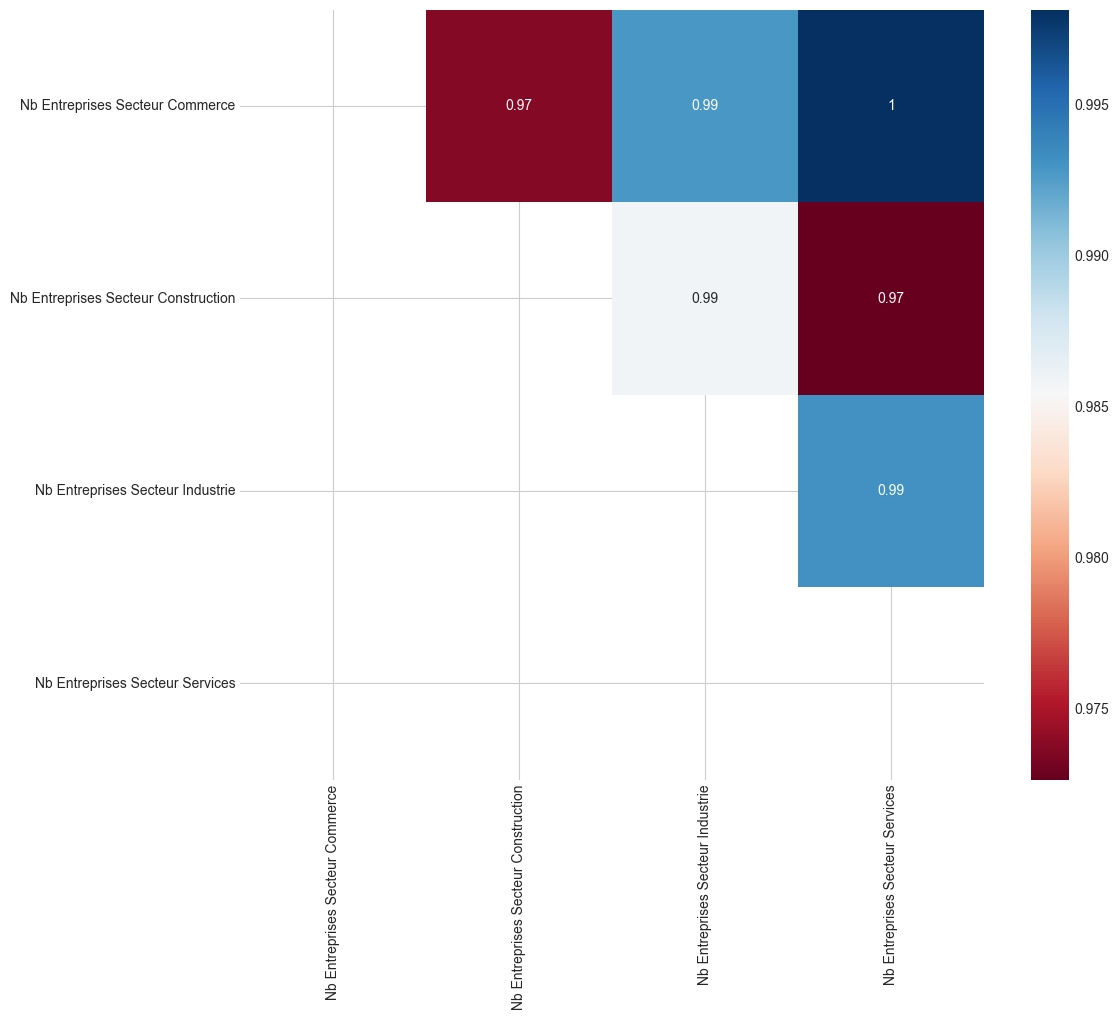

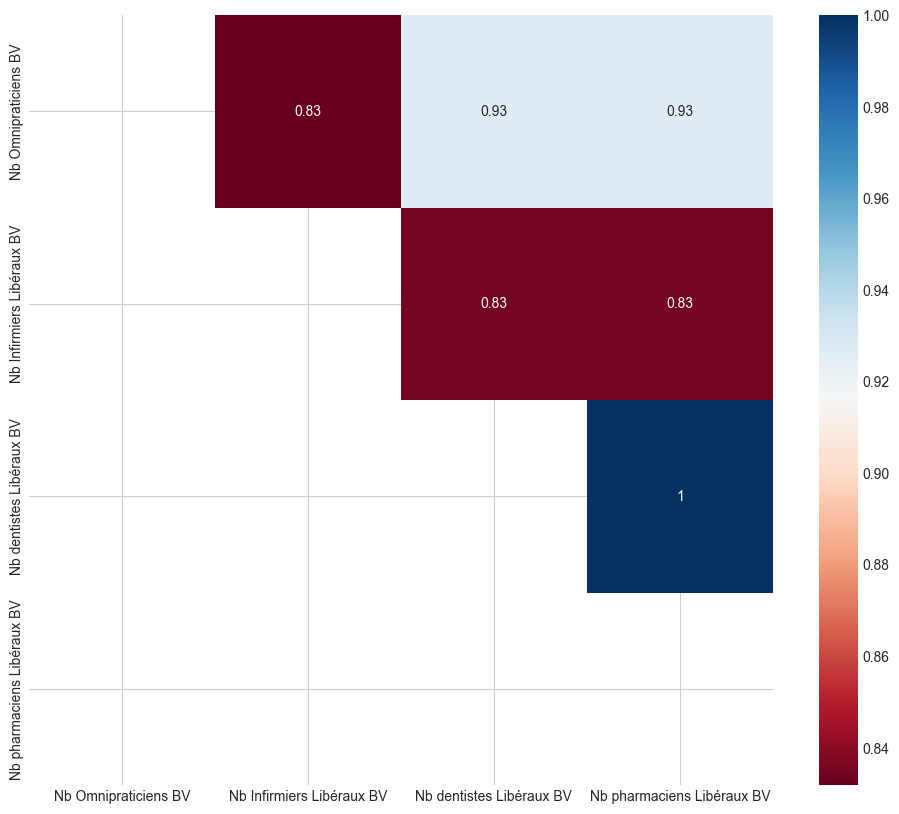

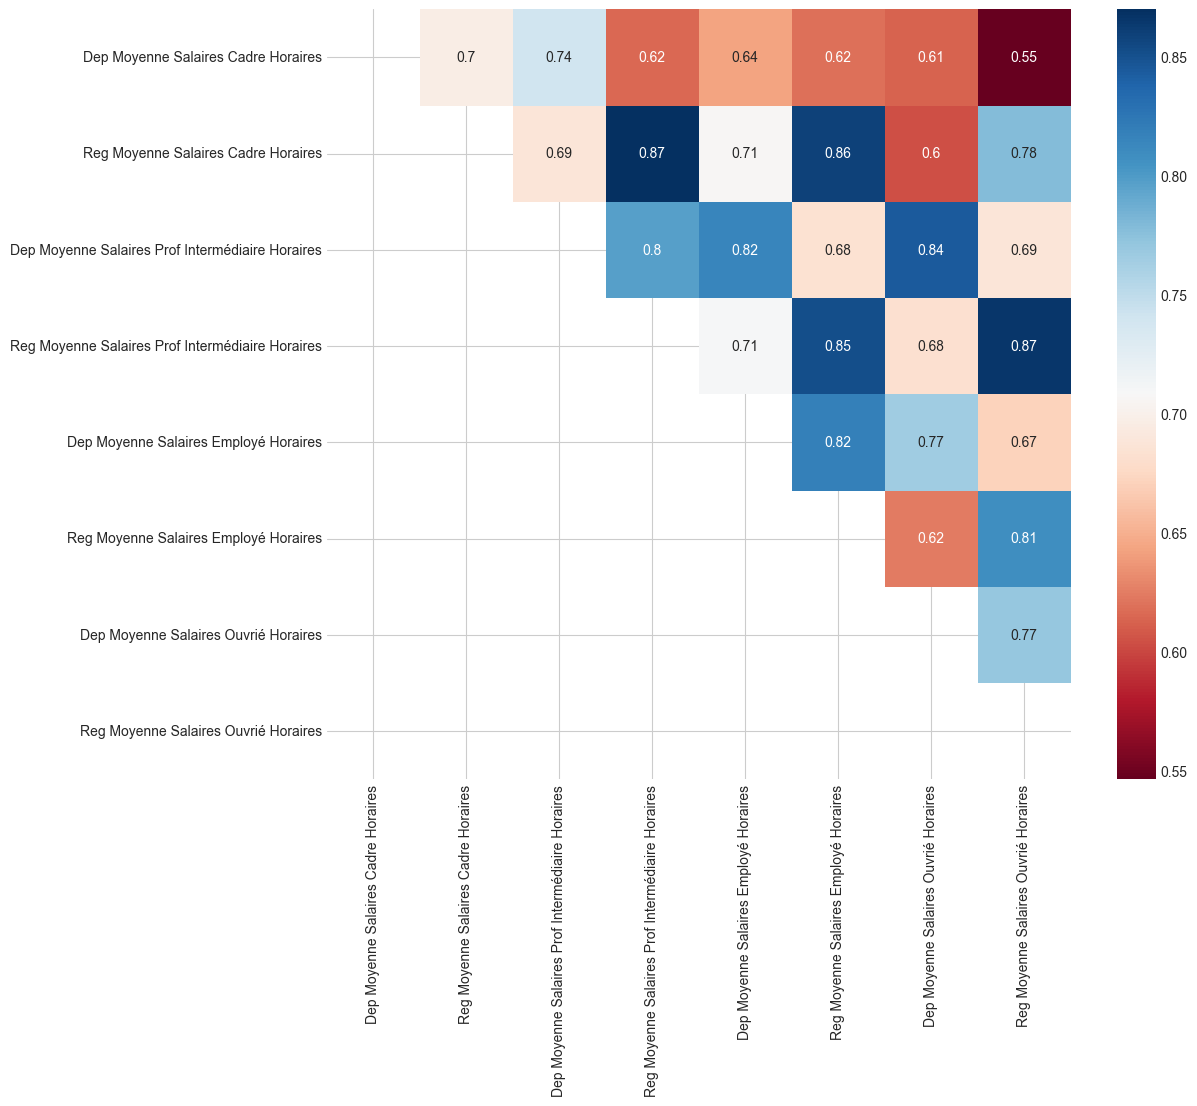

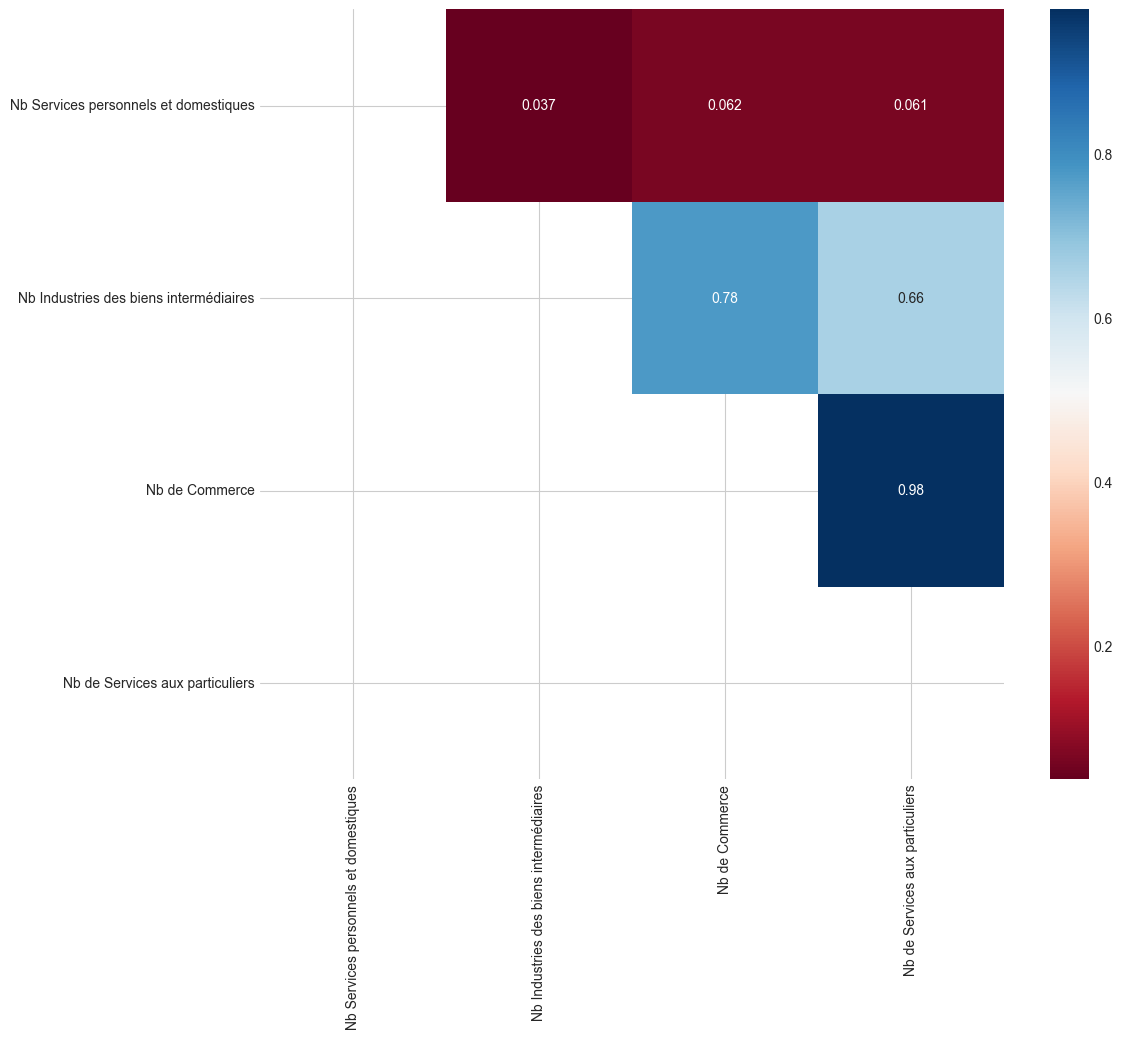

In [ ]:
display_correlation_matrix(insee_divers_df[Nb_entreprises],name="mdb_NB_Entreprises")
display_correlation_matrix(insee_divers_df[Nb_medecins] , name="mdb_Nb_medecins")
display_correlation_matrix(insee_divers_df[indice_salaire_csp] , name="mdb_indice_salaire_csp")
display_correlation_matrix(insee_divers_df[Indice_services] , name="mdb_indice_services")

In [ ]:
mdb_df = insee_divers_df[col_to_keep5].copy()

# nombre d'entreprises
mdb_df['Nb Entreprises'] = insee_divers_df[Nb_entreprises].sum(axis=1)

# nombre de médecins
mdb_df['Nb Medecins'] = insee_divers_df[Nb_medecins].sum(axis=1)
mdb_df.head(3)

# ratio du nombre d'hommes par rapport au femmes
mdb_df['rH/F'] = insee_divers_df[HF[0]] / insee_divers_df[HF[1]]

# ratio du nombre de mineurs par par rapport au majeurs
mdb_df['rm/M'] = insee_divers_df[mM[0]] / insee_divers_df[mM[1]]

# Indice salariaux
for k , v in dict_indice_salaire.items():
    mdb_df[k] = insee_divers_df[v[0]]/insee_divers_df[v[1]]

# indice social
mdb_df['indice_social'] = insee_divers_df[Indice_social].sum(axis=1)

# indice services
mdb_df['indice_services'] = insee_divers_df[Indice_services].sum(axis=1)

mdb_df.to_csv(os.path.join("Tables","MDB_groupe.csv"),index=False)
mdb_df.head(3)

,Nb Actifs Non Salariés,Nb Atifs,Score Démographique,Orientation Economique,Indice Evasion Client,Nb propriétaire,Synergie Médicale COMMUNE,Fidélité,Indice Synergie Médicale,Nb Occupants Résidence Principale,CODGEO,Nb Logement,Taux Evasion Client,Seg Cap Fiscale,Dynamique Entrepreneuriale,Densité Médicale BV,Nb Actifs Salariés,Nb Camping,Nb Hotel,Nb Ménages,DYN SetC,Moyenne Revnus fiscaux,SYN MEDICAL,REG,Score Croissance Entrepreneuriale,Taux Propriété,Score Croissance Population,Nb Pharmacies et parfumerie,Environnement Démographique,Indice Ménages,Valeur ajoutée régionale,Capacité Fiscale,Nb Logement Secondaire et Occasionnel,Taux étudiants,Seg Dyn Entre,Dynamique Entrepreneuriale Service et Commerce,SEG Croissance POP,Score équipement de santé BV,Indice Démographique,Evolution Population,Nb Création Services,Indice Fiscal Partiel,Score VA Région,Score Urbanité,DEP,Score PIB,PIB Régionnal,Dynamique Démographique INSEE,Nb Etudiants,LIBGEO,Nb Entreprises,Nb Medecins,rH/F,rm/M,indice_salaire_global,indice_salaire_cadre,indice_salaire_prof,indice_salaire_employé,indice_salaire_ouvrié,indice_social,indice_services
0,41.000,295.000,0.034,Bassin Industriel,0.000,196,114,Pop Sédentaire,114.567,728,01001,289,0,Fiscalité moyenne,57.000,0.093,254.000,0.000,0.000,247,Faible Dynamique Serv et Com,11483.500,Synergie Médicale,82,0.016,67,72.131,0.000,Bassin Industriel en croissance démographique,37.220,86957.458,117,32.000,0,Faible dynamique,23.000,en croissance démographique,4,44.198,16,1.000,101.939,32.426,0.000,01,33.838,173681,-1,51,L' Abergement-Clémenciat,22.000,37,1.029,1.822,0.961,1.008,0.989,0.995,0.997,15108.000,22087.000
1,8.000,57.000,0.008,Bassin Résidentiel,0.000,61,143,Pop Sédentaire,143.711,168,01002,142,0,Fiscalité moyenne,45.000,0.099,49.000,0.000,0.000,67,Faible Dynamique Serv et Com,11483.500,Forte Synergie Médicale,82,0.002,42,72.131,0.000,Bassin Résidentiel en croissance démographique,10.096,86957.458,110,71.000,0,Faible dynamique,4.000,en croissance démographique,4,10.181,4,1.000,101.939,32.426,0.000,01,33.838,173681,0,5,L' Abergement-de-Varey,5.000,103,1.012,1.629,0.961,1.008,0.989,0.995,0.997,15105.000,22086.000
2,353.000,4556.000,0.538,Bassin Résidentiel,248.455,1968,366,Pop Mobile,367.821,11015,01004,5184,2,Fiscalité moyenne,634.000,0.099,4203.000,0.000,2.000,4640,Bonne Dynamique Entreprise Serv et Com,11483.500,Forte Synergie Médicale,82,0.385,37,72.951,0.000,Bassin Résidentiel en croissance démographique,699.199,86957.458,250,135.000,0,Dynamique Economique,828.000,en croissance démographique,4,696.921,512,38.000,101.939,32.426,37.500,01,33.838,173681,-55,904,Ambérieu-en-Bugey,809.000,103,0.958,1.583,0.961,1.008,0.989,0.995,0.997,15336.000,22127.000


In [ ]:
all_columns(mdb_df)

les colonnes sont : 
Index(['Nb Actifs Non Salariés', 'Nb Atifs', 'Score Démographique',
       'Orientation Economique', 'Indice Evasion Client', 'Nb propriétaire',
       'Synergie Médicale COMMUNE', 'Fidélité', 'Indice Synergie Médicale',
       'Nb Occupants Résidence Principale', 'CODGEO', 'Nb Logement',
       'Taux Evasion Client', 'Seg Cap Fiscale', 'Dynamique Entrepreneuriale',
       'Densité Médicale BV', 'Nb Actifs Salariés', 'Nb Camping', 'Nb Hotel',
       'Nb Ménages', 'DYN SetC', 'Moyenne Revnus fiscaux', 'SYN MEDICAL',
       'REG', 'Score Croissance Entrepreneuriale', 'Taux Propriété',
       'Score Croissance Population', 'Nb Pharmacies et parfumerie',
       'Environnement Démographique', 'Indice Ménages',
       'Valeur ajoutée régionale', 'Capacité Fiscale',
       'Nb Logement Secondaire et Occasionnel', 'Taux étudiants',
       'Seg Dyn Entre', 'Dynamique Entrepreneuriale Service et Commerce',
       'SEG Croissance POP', 'Score équipement de santé BV',
       '

['Nb Actifs Non Salariés',
 'Nb Atifs',
 'Score Démographique',
 'Orientation Economique',
 'Indice Evasion Client',
 'Nb propriétaire',
 'Synergie Médicale COMMUNE',
 'Fidélité',
 'Indice Synergie Médicale',
 'Nb Occupants Résidence Principale',
 'CODGEO',
 'Nb Logement',
 'Taux Evasion Client',
 'Seg Cap Fiscale',
 'Dynamique Entrepreneuriale',
 'Densité Médicale BV',
 'Nb Actifs Salariés',
 'Nb Camping',
 'Nb Hotel',
 'Nb Ménages',
 'DYN SetC',
 'Moyenne Revnus fiscaux',
 'SYN MEDICAL',
 'REG',
 'Score Croissance Entrepreneuriale',
 'Taux Propriété',
 'Score Croissance Population',
 'Nb Pharmacies et parfumerie',
 'Environnement Démographique',
 'Indice Ménages',
 'Valeur ajoutée régionale',
 'Capacité Fiscale',
 'Nb Logement Secondaire et Occasionnel',
 'Taux étudiants',
 'Seg Dyn Entre',
 'Dynamique Entrepreneuriale Service et Commerce',
 'SEG Croissance POP',
 'Score équipement de santé BV',
 'Indice Démographique',
 'Evolution Population',
 'Nb Création Services',
 'Indice Fisca

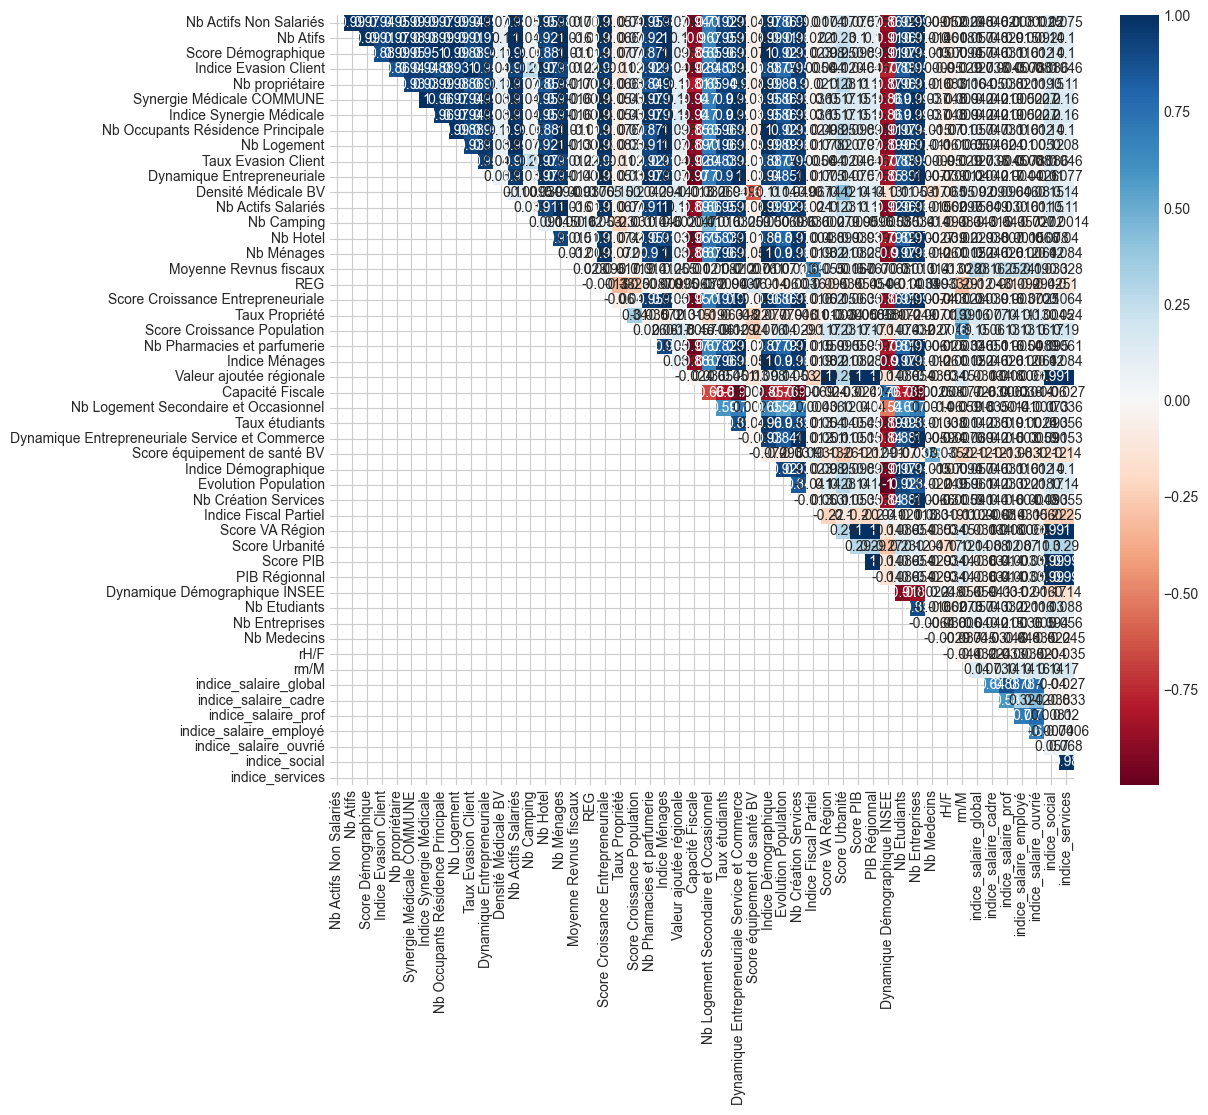

In [ ]:
display_correlation_matrix(mdb_df.copy(), name="corr_mdb")

## 1.3 Fusion des sources fournies et nettoyage

### resultat de la préanalyse

In [ ]:
def safe_feature_selection(X, selected_features):
    """
    Retourne les colonnes de X correspondant aux selected_features valides.
    """
    return X[[feat for feat in selected_features if feat in X.columns]]

merge_list = [(niveau_vie_df , id_niveau),
              (communes_df , id_commune),
              (age_groups , id_age),
              (mdb_df , id_mdb)]

#fonction de fussion
def prepare_datasets(train_data,
                     test_data,
                     merge_list ,
                     base_id = id_train,
                     cols_to_drop = cols_to_drop,
                     verbose=False):
    """
    Fonction pour préparer et fusionner les datasets pour la modélisation
    """
    #Extraire les données de Macron
    train_features = train_data[train_data['Nom']=='MACRON'].copy()
    test_features = test_data.copy()

    # harmoniser les colonnes d'identification
    train_features['CodeINSEE'] = train_features['CodeINSEE'].astype(str).str.zfill(5)
    test_features['CodeINSEE'] = test_features['CodeINSEE'].astype(str).str.zfill(5)

    for i , (df , id_col) in enumerate(merge_list):
        # Vérifier si la colonne d'identification est présente dans le DataFrame
        if id_col not in df.columns:
            raise ValueError(f"La colonne d'identification '{id_col}' n'est pas présente dans le DataFrame à l'index {i}.")

        # Assurer que la colonne d'identification est au format string avec padding
        df[id_col] = df[id_col].astype(str).str.zfill(5)

        # nombre d'échantillons avant la fusion
        n_samples_before = train_features.shape[0]

        # Fusionner les DataFrames sur la colonne d'identification
        train_features = pd.merge(train_features, df, left_on=base_id, right_on=id_col, how='left')

        test_features = pd.merge(test_features, df, left_on=base_id, right_on=id_col, how='left')

        # nombre d'échantillons après la fusion
        n_samples_after = train_features.shape[0]

        assert n_samples_before == n_samples_after, f"Erreur de fusion : le nombre d'échantillons a changé après la fusion avec {id_col}."

        # supprimer l'identifiant
        if id_col != base_id:
            train_features = train_features.drop(columns=[id_col], axis=1, errors='ignore')
            test_features = test_features.drop(columns=[id_col], axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes non informatives
    train_features = train_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    test_features = test_features.drop(columns=cols_to_drop, axis=1, errors='ignore')
    #-----------------------------------------------------------------
    # Supprimer les colonnes d'identification
    train_features = train_features.drop(columns=IDs, axis=1 , errors='ignore')

    if verbose :
        missing1 = ((train_data.isnull().sum()/ train_data.shape[0]).sum()/train_data.shape[1] )* 100
        missing2 = ((train_features.isnull().sum()/ train_features.shape[0]).sum()/train_features.shape[1] )* 100
        #-------------------------------------------------------------
        print(f" {train_features.shape[1]} colonnes vs {train_data.shape[1]} avant la fusion\n")
        print(f" {len(cols_to_drop) + len(merge_list) + 1} colonnes supprimées pendant la fusion \n")
        print(f" \n{train_features.shape[0]} lignes vs {train_data.shape[0]} avant la fusion\n")
        print(f" \n{missing2}% de valeurs manquantes vs {missing1}% avant la fusion")


    return train_features, test_features


NameError: name 'cols_to_drop' is not defined

In [ ]:
train_data , test_data = prepare_datasets(res_train_df, res_test_df,
                                          merge_list,
                                          base_id = id_train,
                                          cols_to_drop = cols_to_drop,
                                          verbose=True)

print(f"forme du train_data : {train_data.shape}")
print(f"forme du test_data : {test_data.shape}")
test_data.head(3)

In [ ]:
X = train_data.drop(columns=[target], axis=1,errors='ignore')
y = train_data[target]

print(X.info())
print(f"forme des prédicteurs : {X.shape}")
print(f"forme de la cible : {y.shape}")


# 2 Prétraitement , et Selection des features

### 2.1 creation de pipeline de prétraitement

In [ ]:
def get_preprocessor(data,features=None):
    """
    Crée un préprocesseur complet avec gestion des valeurs infinies, manquantes et aberrantes
    """
    X=data.copy()
    # Remplacer les valeurs infinies par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    if features is not None:
        X = X[features]

    numeric_features = X.select_dtypes(include=['int64', 'float64',np.number]).columns
    categorical_features = X.select_dtypes(include=['object', 'category','bool']).columns

    # conversion des colonnes catégorielles en type str pour éviter les type mixte
    X[categorical_features] = X[categorical_features].astype(str)


    # Pipeline pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ] ,   memory='cache_directory')

    # Pipeline pour les variables catégorielles
    categorical_transformer = Pipeline(
        steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder( sparse_output=False, handle_unknown='ignore'))
        ])

    # Combinaison des transformateurs
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder = 'drop',
        verbose_feature_names_out=False,
        n_jobs=-1)

    return preprocessor


### 2.2 Selection grossière automatique avec xgboost


In [ ]:
def fast_feature_selection(x_data, y_data, n_features=20,sort=False):
    """
    Selection automatique des ``n_features`` meilleures features avec  XGBoost
    Args:
        X (pd.DataFrame): DataFrame contenant les caractéristiques
        y (pd.Series): Série contenant la cible
        n_features (int): Nombre de features/colonnes à sélectionner
        sort (bool): Si True, trie les features sélectionnées par importance décroissante
    Returns:
        list: Liste des noms des features sélectionnées
    """
    # Créer une copie de X pour éviter les modifications sur l'original
    X = x_data.copy()
    # Supprimer les colonnes avec une variance inférieure à 0.01
    drop, keep = remove_quasi_constant_features(X)

    X = X[keep]
    # Remplacer les valeurs infinies par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    # identification des colonnes numériques et catégorielles
    num_col = X.select_dtypes(include=[np.number,'float64','int64']).columns
    cat_col = X.select_dtypes(include=['object', 'category','bool']).columns

    # transformer tous les colonnes catégorielles en type str
    # pour éviter les types mixtes
    X[cat_col] = X[cat_col].astype(str)

    # Préprocessing light
    preprocessor = make_column_transformer(
        (SimpleImputer(strategy='median'), num_col),
        (Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])              ,            cat_col ),
        remainder='drop',
        verbose_feature_names_out=False,
        n_jobs=-1
    )

    # Modèle unique mais robuste
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectFromModel(
            XGBRegressor(
                tree_method='hist',
                n_estimators=50,
                max_depth=6),
            max_features=n_features
        )),
        ('estimator', XGBRegressor())
    ])

    model.fit(X, y_data)

    transformed_features_names = model.named_steps['preprocessor'].get_feature_names_out(input_features=keep)

    if sort:

        importances = model.named_steps['estimator'].feature_importances_

        feature_importance = list(zip(transformed_features_names, importances))

        feature_importance.sort(key=lambda x: x[1], reverse=True)

        selected_features = [name for name, _ in feature_importance[:n_features]]

    selected_indices = model.named_steps['selector'].get_support(indices=True)

    selected_features = [transformed_features_names[i] for i in selected_indices]

    return list(selected_features)


### 2.3 Selection plus fine pour un modèle donné

In [ ]:

def compute_rmse(pipeline , X_sub, y,cv=None,
                 message="Début du calcul...",
                 error="une erreur s'est produite")->float:
    """
    Function to compute cross-validated RMSE
    """
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    if message is not None:
        print(message)
    try :
        pipeline.fit(X_sub, y)
        # Calculer le RMSE avec validation croisée
        scores = cross_val_score(pipeline, X_sub, y,
                                scoring='neg_root_mean_squared_error',
                                cv=cv,n_jobs=-1)
        return -scores.mean()
    except Exception as e:
        if error is not None:
            print(error)
            print(f"Erreur : {e}")
        # Si une erreur se produit, on retourne une valeur élevée pour forcer la suppression de la feature
        return float('inf')


def backward_stepwise(model, X, y,
                       initial_features:List[str]=None,
                       min_features:int=3,
                       rtol:float=0.005,
                       max_degrad:float=0.005,
                       cv=None,
                       logg:bool=True)->Tuple[List[str] , float]:
    """
    Backward stepwise feature selection algorithm.

    Parameters:
    - model: The predictive model (must implement fit and predict).
    - X: DataFrame of predictors.
    - y: Target variable.
    - initial_features: Initial subset of features to test. If None, uses all features.
    - min_features: Minimum number of features to keep.
    - max_degrad: Maximum allowed degradation in RMSE to consider a feature removable.
    - rtol: Relative tolerance for improvement in RMSE. If improvement < rtol, stops early.

    Returns:
    - best_features: List of selected features.
    - best_score: Best RMSE score achieved.
    """


    all_features = X.columns.tolist()
    if initial_features is None:
        current_features = all_features.copy()
    else:
        current_features = [f for f in initial_features if f in all_features]

    if min_features is None:
        min_features = max(5, int(0.1 * len(current_features)))

    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    pipeline = Pipeline([
        ('preprocessor' , get_preprocessor(X , current_features)),
        ('model', model)
    ] )

    # Compute initial RMSE
    best_score = compute_rmse(pipeline,
                              X[current_features], y,cv=cv , message="calcul du score initial..." if logg else None,
                              error="Erreur lors de l'évaluation initiale" if logg else None)

    if logg:
        print("début des suppressions...\nInitial RMSE: {best_score:.4f}")
    features_removed = []
    improve = True
    while improve and len(current_features) > min_features:
        worst_feature = None
        current_rmse = best_score
        # essai de suppression de chaque feature
        for feature in current_features:
            trial_features = [f for f in current_features if f != feature]
            trial_pipeline = Pipeline([
                ('preprocessor',get_preprocessor(X,trial_features)),
                ('model' ,model)
            ])
            # Compute RMSE without the feature
            trial_rmse = compute_rmse(trial_pipeline,
                                      X[trial_features], y,cv=cv,message=f"Test sans '{feature}'"if logg else None,error=f"Erreur en testant sans {feature} "if logg else None)

            relative_change = (best_score-trial_rmse) / best_score
            # If removing the feature improves RMSE beyond rtol
            if relative_change >= rtol and trial_rmse < current_rmse:
                    current_rmse = trial_rmse
                    worst_feature = feature
            elif relative_change < -max_degrad:
                if logg:
                    print(f" suppression de {feature} rejetée : dégradation de {-relative_change*100:.2f} %")

        # Remove the worst feature if found
        if worst_feature is not None:
            current_features.remove(worst_feature)
            features_removed.append(worst_feature)
            best_score = current_rmse
            improve = True
            if logg:
                print(f" '{worst_feature}' supprimée  , nouvelle RMSE: {best_score:.4f},  {len(current_features)} features restante")
        else:
            improve = False

    if logg:
        print(f"selction terminée {len(current_features)} Features conservées. RMSE final: {best_score:.4f}")
    return current_features, best_score



#  3. Construction des modèles

## Séparation des données

In [ ]:
train_data , test_data = prepare_datasets(res_train_df, res_test_df,
                                          merge_list,
                                          base_id = id_train,
                                          cols_to_drop = cols_to_drop,
                                          verbose=True)

In [ ]:
X = train_data.drop(columns=[target], axis=1,errors='ignore')
y = train_data[target]


In [ ]:

# selection des 20 meilleures features
selected_features = fast_feature_selection(X, y, n_features=20)

pd.DataFrame(selected_features , columns = ["feature"]).to_csv(os.path.join("Tables" , "20_best_features.csv"),index=False)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(safe_feature_selection(X , selected_features) , y , test_size=0.2 , train_size=0.8 , shuffle=True , random_state=42)

## Comparaison , Selection et optimisation du meilleur modèle

In [ ]:
def compare_models(models: Dict[str, Tuple],
                        X_train: pd.DataFrame,
                        y_train: pd.Series,
                        X_test:pd.DataFrame ,
                        y_test:pd.Series,
                        save:bool=True,
                        title:str = ""
                        ) -> Tuple[pd.DataFrame, Dict[str, Pipeline]]:
    """
    Compare plusieurs modèles de régression à l'aide de GridSearchCV rapide.

    Args
    ----
    - models : dict où chaque clé est le nom du modèle et la valeur est un dictionnaire (modèle sklearn, features ,grille d'hyperparamètres)
    - X_train ,y_train : données d'entraînement
    - X_test , y_test : données de validation

    Returns:
    - results_df: DataFrame des scores RMSE , MAE , r2
    - best_models: dictionnaire des pipelines optimaux entraînés
    """
    results = []
    pipelines = {}

    print(f"\nModèles à comparer :",models.keys())
    for name, info in models.items():
        print(f"\n métriques de {name}...")

        model = info["model"]
        feat = info["features"]
        features = feat.copy()
        if feat ==[]:
            features = X_train.columns.tolist()

        pipe = Pipeline([
            ('preprocessor' , get_preprocessor(X,features)),
            ('model' , model)
        ])

        pipe.fit(X_train , y_train)
        y_pred = pipe.predict(X_test)


        # résultats
        results.append({
            "Model": name,
            "RMSE": np.sqrt(mean_squared_error(y_test,y_pred)),
            "MAE": mean_absolute_error(y_test , y_pred),
            "r2" : r2_score(y_test,y_pred)
        })
        pipelines[name] = pipe

    results_df = pd.DataFrame(results)
    results_df=results_df.sort_values(by="RMSE")
    if save :
        results_df.to_csv(os.path.join("Tables" , f"{title}.csv") , index=False)
    return results_df, pipelines


### comparaison n°1


In [ ]:
models_simple = {
    "Lasso": {
        "model":Lasso(),
        "features":[],
        "param_grid":{}
        },
    "XGBoost": {
        "model":XGBRegressor(),
        "features":[],
        "param_grid":{}
        }
}

res1 , _ = compare_models(models_simple,X_train,y_train,X_test,y_test,save =True , title= "comparaison1")
basique_best_model_name = res1.iloc[0]['Model']

print("\n",res1)
print(f" \nLe meilleur modèle basique est {basique_best_model_name}")


### comparaison n°2

In [ ]:
# backward_stepwise sur chaque modèle pour determiner ses features optimaux
models_info = {}
for name, info in models_simple.items():
    print(f"\nSélection de features pour {name}...")
    features = backward_stepwise(
        model=info["model"],
        X=X_train,
        y=y_train,
        min_features=5,
        logg=False
    )[0]
    info["features"] = features
    print("\n",features)
    print(f"selection terminée")
    models_info[name]=info


In [ ]:
# # Comparaison
results2 , pipelines = compare_models(models_simple, X_train, y_train,X_test,y_test,save=True, title="comparaison2")

print("\n",results2)

feat_best_model_name = results2.iloc[0]['Model']
print(f" \nle meilleur modèle basique avec de bonne features est {feat_best_model_name}")


### comparaison n°3

In [ ]:
param_distributions = {
    "Lasso": {
        'alpha': uniform(0.01, 0.09),

    },
    "XGBoost": {
        'n_estimators': randint(50, 90),
        'max_depth': [3],
        'learning_rate': uniform(0.05, 0.1)
    }
}

# Ajout des grilles de recherche  dans  models_info
for name , info in models_info.items():
    info["param_grid"] = param_distributions[name]

# Tunning des modèles avec leur best features et mise à jour de models_info
for name , info in models_info.items():
    grid_pref = {'model__'+k:v for k,v in info['param_grid'].items()}
    model = info["model"]
    features = info["features"]
    print(f"\n randomsearch pour {name}....")
    pipe = Pipeline([
        ('preprocessor' , get_preprocessor(X_train,features)),
        ('model' , model)
    ])
    grid = RandomizedSearchCV(
        pipe,
        grid_pref,
        scoring='neg_root_mean_squared_error',
        cv = 3 ,
        n_jobs=-1,
        verbose=3,
        n_iter=1
        )
    grid.fit(X_train[features],y_train)
    info["pipeline"] = grid.best_estimator_
    info["params"] = grid.best_params_
    print(f"randomsearch terminée ! ")

#  comparaison
results3 , pipelines_final = compare_models(models_info,
                                            X_train,y_train,
                                            X_test,y_test,
                                            save=True , title="comparaison3")

print("\n" , results3)
print(f"\n le meilleur modèle ")


In [ ]:
model = class1
grid_param = grille
preprocessor = get_preprocessor(X_train,features)
pip = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])
grid = RandomizedSearchCV(
        pipe,
        grid_pref,
        scoring='neg_root_mean_squared_error',
        cv = 3 ,
        n_jobs=-1,
        verbose=3,
        n_iter=1
        )
grid.fit(X_train[features],y_train)
info["pipeline"] = grid.best_estimator_
info["params"] = grid.best_params_
print(f"randomsearch terminée ! ")



### Selection automatique du modèle et affinage

In [ ]:
best_model_name = results3.iloc[0]['Model']
final_best_features = models_info[best_model_name]["features"]
best_model = models_info[best_model_name]["model"]

print(f"\nLe meilleur modèle final est {best_model_name}")

# grille fine pour le meilleur modèle
fines_grid = {
    "Lasso": {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
        'max_iter': [500, 1000, 2000, 5000],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random'],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    "XGBoost": {
        'n_estimators': [100, 300],
        'max_depth': [ 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5, 1, 2],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0.1, 0.5, 1, 2],
        'min_child_weight': [1, 3, 5]
    }
}

#mise à jour de models_info
for name , info in models_info.items():
    info["is_better"] = (name==best_model_name)
    models_info[best_model_name]["param_grid"] = fines_grid.get(best_model_name)


In [ ]:
display(pd.DataFrame(models_info))

In [ ]:
best_model_name = results3.iloc[0]['Model']
final_best_features = models_info[best_model_name]["features"]
best_model = models_info[best_model_name]["model"]

print(f"\nLe meilleur modèle final est {best_model_name}")

# grille fine pour le meilleur modèle
fines_grid = {
    "Lasso": {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
        'max_iter': [500, 1000, 2000, 5000],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random'],
        'tol': [1e-4, 1e-3, 1e-2]
    },
    "XGBoost": {
        'n_estimators':[100, 300],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.01, 0.2],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'min_child_weight': [2, 4]
    }
}

#mise à jour de models_info
for name , info in models_info.items():
    info["is_better"] = (name==best_model_name)
    models_info[best_model_name]["param_grid"] = fines_grid.get(best_model_name)


In [ ]:
print(f"\n affinage de  {best_model_name}....")
pipe = Pipeline([
    ('preprocessor' , get_preprocessor(X_train,features)),
    ('model' , best_model)
])
grid_pref2 = {'model__'+k:v for k,v in models_info[best_model_name]["param_grid"].items()}
grid2 = GridSearchCV(
    pipe,
    grid_pref2,
    scoring='neg_root_mean_squared_error',
    cv =3 ,
    n_jobs=-1,
    verbose=1)

grid2.fit(X_train[final_best_features],y_train)

final_best_pipeline = grid2.best_estimator_
final_best_params = grid.best_params_
print(f"Grisdsearch terminée ! ")
binfo = models_info[best_model_name]
binfo["Pipeline"] = final_best_pipeline
binfo["params"] = final_best_params

## Graphiques d'analyse

In [ ]:
model_for_graph = {}
for name , info in models_info.items():
    model_for_graph[name] = {
        "pipeline":info.get("pipeline"),
        "features":info.get("features"),
        "model":info.get("model")
    }


In [ ]:
def analyze_model_predictions(y_true, y_pred, model_name=""):
    """
    Génère des graphiques d'analyse des performances d'un modèle de régression :
    - Résidus vs Prédictions
    - Histogramme des résidus
    - QQ-plot
    - Vraies vs Prédictions
    - Affichage des métriques

    Args:
    - y_true: valeurs réelles
    - y_pred: prédictions du modèle
    - model_name: nom du modèle (affiché sur les titres)
    """
    residuals = y_true - y_pred
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Évaluation du {model_name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    plt.figure(figsize=(15, 10))

    # Résidus vs Prédictions
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Prédictions")
    plt.ylabel("Résidus")
    plt.title("Résidus vs Prédictions")

    # Histogramme des résidus
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title("Distribution des résidus")

    # QQ-plot
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("QQ-Plot des résidus")

    # Vraies vs Prédictions
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Vraies valeurs")
    plt.ylabel("Prédictions")
    plt.title("Vraies vs Prédictions")

    plt.suptitle(f"Analyse du {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join("Figures" , f"graphs_analyse_model_{model_name}.png"))
    plt.show()

#-------------------------------------------------------------------------------
def plot_feature_importance(model, feature_names, model_name=""):
    """
    Trace l'importance des features pour un modèle donné.
    """
    if hasattr(model, "coef_"):
        importances = model.coef_
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        print(f"Aucune importance de feature disponible pour {model_name}")
        return

    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.abs(importances)[sorted_idx], y=np.array(feature_names)[sorted_idx])
    plt.title(f"Importance des variables - {model_name}")
    plt.xlabel("Importance absolue")
    plt.ylabel("Variables")
    plt.tight_layout()
    plt.savefig(os.path.join("Figures",f"importances_{model_name}.png"))
    plt.close()

#----------------------------------------------------------------
def analyze_all_models(models_info , X_test, y_test):
    """
    Applique l'analyse des prédictions à tous les modèles comparés.
    """
    for model_name, info in models_info.items():
        features = info.get("features" , X_test.columns.tolist())
        pipeline = info.get("pipeline")
        x_val = safe_feature_selection(X_test, features) if features else X_test

        y_pred = pipeline.predict(X_test[features])
        analyze_model_predictions(y_test, y_pred, model_name)



# tracer les graphiques pour les analyses des trois modèles
analyze_all_models(model_for_graph , X_test, y_test)


# graphique de l'importance des features pour le meilleur modèle
for name , dico in model_for_graph.items():
    plot_feature_importance(dico["model"] , dico["features"], model_name = name)

# 4. Soumission sur Kaggle

In [ ]:
# copier le fichier de test déja merge
data_test = test_data.copy()

# selectionner les features optimaux pour le best_model
data_test_submit = safe_feature_selection(data_test,final_best_features)

# Calcul des prédictions sur le dataset de test final
y_pred_test = final_best_pipeline.predict(data_test_submit)

# Ajout des prédictions au dataframe
data_test['Prediction'] = y_pred_test

submission = data_test[['CodeINSEE', 'Prediction']]

# sauvegarder la liste des features
with open(f"final_best_features_with_{best_model_name}.json" , 'w') as file:
    json.dump(final_best_features , file)

# sauvegarder les prédictions
submission.to_csv('results_test_predicted.csv', index=False)
print(f"\nFichier de soumission 'results_test_predicted.csv' généré avec succès \nForme {submission.shape}  ")

submission.head(5)